# Theme Park Attendance Forecasting Dataset

This dataset is a synthetically generated timeseries specifically designed for the purpose of forecasting attendance at a fictitious theme park in Los Angeles. The dataset spans from January 1, 2016, to February 15, 2019, and includes various factors that influence daily attendance numbers. These factors are intended to simulate real-world conditions affecting theme park visitation.

The dataset is built upon a set of deterministic and stochastic components, ensuring both structured patterns and random variability, essential for robust forecasting model testing:

1. **Weather Factors**: Each day is characterized by maximum temperature (`max_temp`) and precipitation (`precipitation`). These weather variables directly influence the attendance through `maxtemp_factor` and `precip_factor`. The factors are designed to decrease attendance when extreme weather conditions occur, like very high temperatures or heavy rainfall.

2. **Time-based Factors**:
   - **Weekday Effect (`weekday_effect`)**: This factor accounts for variations in attendance based on the day of the week, capturing typical weekly cycles in visitor numbers.
   - **Week of Year Effect (`week_of_year_effect`)**: Reflecting seasonal trends, this factor changes with the week number of the year, acknowledging holidays, school vacations, and season-specific events.
   - **Holiday Effect (`holiday_effect`)**: The dataset uniquely marks not only specific holidays but also the days surrounding them (3 days before, the day of the holiday, and 2 days after). It's important to note that holidays are marked based on when the federal holiday was observed. For instance, in 2016, although Christmas Day fell on December 25th (a Sunday), the holiday was officially observed on December 26th (Monday), and the dataset reflects this observation. The holiday effect adjusts factors to signify increased or decreased attendance during these periods.

3. **Stochastic Components**:
   - **Random Walk Factor (`random_walk_factor`)**: Introduced to model unpredictable yet sequential fluctuations, this factor starts at 1 and evolves daily by a random multiplier between 0.999 and 1.001.
   - **White Noise Factor (`white_noise_factor`)**: Drawn from a standard normal distribution with a mean of 1.0 and a standard deviation of 0.02, this factor adds randomness to the dataset, simulating day-to-day volatility in attendance.

The dataset's final output, `final_attendance`, is a product of the baseline attendance, weather, time-based factors, and stochastic components. It represents the synthesized daily attendance figure at the theme park.

This structured yet diverse dataset serves multiple purposes:

- **Forecasting Model Development**: It provides a rich scenario for developing and testing time series forecasting models, given its mix of predictable and random elements.
- **Impact Analysis**: The dataset allows for the examination of how various factors (like weather, holidays, and stochastic elements) impact theme park attendance.
- **Simulation of Real-world Scenarios**: The combination of regular patterns (weekly and annual cycles) with random fluctuations offers a realistic representation of theme park attendance dynamics.

The dataset is saved in a CSV format with columns for each exogenous factor and the synthesized daily attendance figure, offering a comprehensive platform for advanced time series analysis and forecasting model development.

In [944]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [945]:
dataset_name = "theme_park_attendance"

In [946]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

In [947]:
holiday_dates_fpath = "./data/holiday_dates.csv"
holiday_factors_fpath = "./data/holiday_factors.csv"
los_angeles_weather_fpath = "./data/los_angeles_weather.csv"
week_factors_fpath = "./data/week_factors.csv"
weekday_factors_fpath = "./data/weekday_factors.csv"

# Read Data

In [948]:
holiday_dates_df = pd.read_csv(holiday_dates_fpath)
holiday_factors_df = pd.read_csv(holiday_factors_fpath)
weather_df = pd.read_csv(los_angeles_weather_fpath)
week_factors_df = pd.read_csv(week_factors_fpath)
weekday_factors_df = pd.read_csv(weekday_factors_fpath)

# Initiate with Weather Data

In [949]:
# Initializing the DataFrame using the weather data
# The 'date' column will be parsed as datetime objects for easier manipulation
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%m/%d/%Y')

# Setting up the initial DataFrame for the timeseries
timeseries_df = weather_df[['date', 'maxtemp_celsius', 'precip_millimeters']].copy()
timeseries_df.rename(columns={'maxtemp_celsius': 'max_temp', 'precip_millimeters': 'precipitation'}, inplace=True)

# Displaying the first few rows of the initialized DataFrame
timeseries_df.head()

,date,max_temp,precipitation
0,2016-01-01,18,0.0
1,2016-01-02,19,0.0
2,2016-01-03,17,0.0
3,2016-01-04,18,0.0
4,2016-01-05,14,37.8


# Apply baseline attendance

In [950]:
# Defining a constant for baseline attendance
baseline_attendance = 24000

# Creating a column 'attendance' and setting it to baseline_attendance
timeseries_df['attendance'] = baseline_attendance

# Displaying the first few rows of the DataFrame with the new column
timeseries_df.head()

,date,max_temp,precipitation,attendance
0,2016-01-01,18,0.0,24000
1,2016-01-02,19,0.0,24000
2,2016-01-03,17,0.0,24000
3,2016-01-04,18,0.0,24000
4,2016-01-05,14,37.8,24000


# Weekday effect

In [951]:
# Adding a 'weekday' column to the timeseries DataFrame
# The 'weekday' method returns the day of the week as an integer, where Monday is 0 and Sunday is 6.
# Adding 1 to align with the specified format: 1 (Monday) through 7 (Sunday)
timeseries_df['weekday'] = timeseries_df['date'].dt.weekday + 1

# Merging the weekday_factors DataFrame with the timeseries DataFrame
# This will add the 'scaled_factor' from weekday_factors to the timeseries DataFrame
timeseries_df = timeseries_df.merge(weekday_factors_df[['weekday_num', 'scaled_factor']], 
                                    left_on='weekday', right_on='weekday_num', how='left')

# Renaming the 'scaled_factor' column to 'weekday_effect'
timeseries_df.rename(columns={'scaled_factor': 'weekday_effect'}, inplace=True)

# Dropping the 'weekday_num' column as it's redundant
timeseries_df.drop('weekday_num', axis=1, inplace=True)

# Displaying the first few rows of the DataFrame
timeseries_df.head()

,date,max_temp,precipitation,attendance,weekday,weekday_effect
0,2016-01-01,18,0.0,24000,5,1.037
1,2016-01-02,19,0.0,24000,6,1.728
2,2016-01-03,17,0.0,24000,7,1.556
3,2016-01-04,18,0.0,24000,1,0.778
4,2016-01-05,14,37.8,24000,2,0.691


# Week of year effect

In [952]:
# Adding a 'week_of_year' column to the timeseries DataFrame
# Since the week is defined as starting on Monday and ending on Sunday, with the first week containing January 1,
# we use the ISO week date system.
timeseries_df['week_of_year'] = timeseries_df['date'].dt.isocalendar().week

# Merging the week_factors DataFrame with the timeseries DataFrame
# This will add the 'scaled_factor' from week_factors to the timeseries DataFrame
timeseries_df = timeseries_df.merge(week_factors_df[['week_num', 'scaled_factor']], 
                                    left_on='week_of_year', right_on='week_num', how='left')

# Renaming the 'scaled_factor' column to 'week_of_year_effect'
timeseries_df.rename(columns={'scaled_factor': 'week_of_year_effect'}, inplace=True)

# Dropping the 'week_num' column as it's redundant
timeseries_df.drop('week_num', axis=1, inplace=True)

# Displaying the first few rows of the DataFrame to confirm the changes
timeseries_df.head()


,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217


# Holiday Effect

## Mark holiday context on the timeline

In [953]:
# Converting the holiday dates to datetime objects for easier manipulation
holiday_dates_df['holiday_dates'] = pd.to_datetime(holiday_dates_df['holiday_dates'], format='%m/%d/%Y')

# Creating a dictionary to map each date to its corresponding holiday and the days surrounding it
holiday_dict = {}
for index, row in holiday_dates_df.iterrows():
    holiday = row['holiday']
    date = row['holiday_dates']
    # Mapping the holiday and the days surrounding it
    holiday_dict[date] = f'{holiday}'
    holiday_dict[date - pd.Timedelta(days=1)] = f'{holiday}_minus1'
    holiday_dict[date - pd.Timedelta(days=2)] = f'{holiday}_minus2'
    holiday_dict[date - pd.Timedelta(days=3)] = f'{holiday}_minus3'
    holiday_dict[date + pd.Timedelta(days=1)] = f'{holiday}_plus1'
    holiday_dict[date + pd.Timedelta(days=2)] = f'{holiday}_plus2'


# Adding the 'holiday' column to the timeseries DataFrame
timeseries_df['holiday_context'] = timeseries_df['date'].map(holiday_dict)
timeseries_df['holiday_context'] = timeseries_df['holiday_context'].fillna("None")

timeseries_df.head()

,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142,New Years Day
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142,New Years Day_plus1
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142,New Years Day_plus2
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217,None
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217,None


## Apply factors based on holiday context

In [954]:
# Pivoting the holiday_factors DataFrame to make it easier to merge with the timeseries DataFrame
holiday_factors_pivot_df = holiday_factors_df.melt(id_vars=['holiday'], var_name='holiday_context', value_name='factor')
holiday_factors_pivot_df.head()

,holiday,holiday_context,factor
0,New Years Day,Day_minus3,1.0
1,MLK Day,Day_minus3,1.1
2,Memorial Day,Day_minus3,1.1
3,Independence Day,Day_minus3,1.1
4,Labor Day,Day_minus3,1.1


In [955]:

# Creating a function to generate the holiday_effect based on the holiday and its surrounding days
def get_holiday_effect(row, holiday_factors_pivot_df):
    if pd.isna(row['holiday_context']):
        return 1.0  # Default factor when there's no holiday
    vals = row['holiday_context'].rsplit('_', 1)
    if len(vals) == 1: 
        holiday_name = vals[0]
        factor = holiday_factors_pivot_df[(holiday_factors_pivot_df['holiday'] == holiday_name) & 
                                      (holiday_factors_pivot_df['holiday_context'] == 'Day')]['factor']
    else:
        holiday_name, holiday_day = vals[0], vals[1]
        factor = holiday_factors_pivot_df[(holiday_factors_pivot_df['holiday'] == holiday_name) & 
                                          (holiday_factors_pivot_df['holiday_context'] == f'Day_{holiday_day}')]['factor']
    return factor.values[0] if not factor.empty else 1.0


# Applying the function to create the 'holiday_effect' column
timeseries_df['holiday_effect'] = timeseries_df.apply(get_holiday_effect, axis=1, args=(holiday_factors_pivot_df,))

# Displaying the first few rows of the DataFrame
timeseries_df.head()


,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142,New Years Day,1.2
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142,New Years Day_plus1,1.1
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142,New Years Day_plus2,1.0
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217,None,1.0
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217,None,1.0


## Pivot the holiday context Column

In [956]:
# Creating dummy variables for each holiday
holiday_dummies = pd.get_dummies(timeseries_df['holiday_context'])

# Converting the True/False values to 1/0
holiday_dummies = holiday_dummies.astype(int)

# Merging the dummy DataFrame with the sample DataFrame
timeseries_df = timeseries_df.join(holiday_dummies)
timeseries_df.head()

,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect,...,Thanksgiving Day_minus2,Thanksgiving Day_minus3,Thanksgiving Day_plus1,Thanksgiving Day_plus2,Veterans Day,Veterans Day_minus1,Veterans Day_minus2,Veterans Day_minus3,Veterans Day_plus1,Veterans Day_plus2
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142,New Years Day,1.2,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142,New Years Day_plus1,1.1,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142,New Years Day_plus2,1.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217,None,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217,None,1.0,...,0,0,0,0,0,0,0,0,0,0


# Weather Effect

In [957]:
# Function to calculate max temperature factor
def maxtemp_factor(temp):
    if 10 <= temp <= 30:
        return 1.0
    elif temp > 30:
        return 1.0 - (0.01 * (temp - 30))
    else:  # temp < 10
        return 1.0 - (0.01 * (10 - temp))

# Function to calculate precipitation factor
def precip_factor(precip):
    if 0 <= precip <= 10:
        return 1.0
    else:  # precip > 10
        return 1.0 - (0.007 * (precip - 10))

# Applying the functions to calculate 'maxtemp_factor' and 'precip_factor'
timeseries_df['maxtemp_factor'] = timeseries_df['max_temp'].apply(maxtemp_factor)
timeseries_df['precip_factor'] = timeseries_df['precipitation'].apply(precip_factor)

# Displaying the first few rows of the DataFrame with the new columns
timeseries_df.head()


,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect,...,Thanksgiving Day_plus1,Thanksgiving Day_plus2,Veterans Day,Veterans Day_minus1,Veterans Day_minus2,Veterans Day_minus3,Veterans Day_plus1,Veterans Day_plus2,maxtemp_factor,precip_factor
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142,New Years Day,1.2,...,0,0,0,0,0,0,0,0,1.0,1.0000
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142,New Years Day_plus1,1.1,...,0,0,0,0,0,0,0,0,1.0,1.0000
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142,New Years Day_plus2,1.0,...,0,0,0,0,0,0,0,0,1.0,1.0000
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217,None,1.0,...,0,0,0,0,0,0,0,0,1.0,1.0000
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217,None,1.0,...,0,0,0,0,0,0,0,0,1.0,0.8054


# Random Walk Factor

In [958]:
# Seed for reproducibility
np.random.seed(1)

# Creating the random walk factor
random_walk = [1]
for _ in range(1, len(timeseries_df)):
    random_walk.append(random_walk[-1] * np.random.uniform(0.995, 1.005))
timeseries_df['random_walk_factor'] = random_walk

timeseries_df.tail()

,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect,...,Thanksgiving Day_plus2,Veterans Day,Veterans Day_minus1,Veterans Day_minus2,Veterans Day_minus3,Veterans Day_plus1,Veterans Day_plus2,maxtemp_factor,precip_factor,random_walk_factor
1137,2019-02-11,16,0.0,24000,1,0.778,7,1.149,None,1.0,...,0,0,0,0,0,0,0,1.0,1.0000,0.999802
1138,2019-02-12,19,0.0,24000,2,0.691,7,1.149,None,1.0,...,0,0,0,0,0,0,0,1.0,1.0000,1.002332
1139,2019-02-13,14,6.2,24000,3,0.605,7,1.149,None,1.0,...,0,0,0,0,0,0,0,1.0,1.0000,1.005401
1140,2019-02-14,16,58.3,24000,4,0.605,7,1.149,None,1.0,...,0,0,0,0,0,0,0,1.0,0.6619,1.007931
1141,2019-02-15,14,1.4,24000,5,1.037,7,1.149,None,1.0,...,0,0,0,0,0,0,0,1.0,1.0000,1.003699


# White Noise Factor

In [959]:
# Seed for reproducibility
np.random.seed(13)

# Creating the white noise factor
# Drawing from a standard normal distribution with mean 1.0 and standard deviation 0.02
timeseries_df['white_noise_factor'] = np.random.normal(1.0, 0.02, len(timeseries_df))

timeseries_df.tail()

,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect,...,Veterans Day,Veterans Day_minus1,Veterans Day_minus2,Veterans Day_minus3,Veterans Day_plus1,Veterans Day_plus2,maxtemp_factor,precip_factor,random_walk_factor,white_noise_factor
1137,2019-02-11,16,0.0,24000,1,0.778,7,1.149,None,1.0,...,0,0,0,0,0,0,1.0,1.0000,0.999802,1.020637
1138,2019-02-12,19,0.0,24000,2,0.691,7,1.149,None,1.0,...,0,0,0,0,0,0,1.0,1.0000,1.002332,1.021899
1139,2019-02-13,14,6.2,24000,3,0.605,7,1.149,None,1.0,...,0,0,0,0,0,0,1.0,1.0000,1.005401,1.003592
1140,2019-02-14,16,58.3,24000,4,0.605,7,1.149,None,1.0,...,0,0,0,0,0,0,1.0,0.6619,1.007931,0.983317
1141,2019-02-15,14,1.4,24000,5,1.037,7,1.149,None,1.0,...,0,0,0,0,0,0,1.0,1.0000,1.003699,1.038169


# Final attendance numbers

In [960]:
# Calculating the final attendance with the new factors
timeseries_df['final_attendance'] = timeseries_df['attendance'] * timeseries_df['weekday_effect'] * \
                                                     timeseries_df['week_of_year_effect'] * timeseries_df['holiday_effect'] * \
                                                     timeseries_df['maxtemp_factor'] * timeseries_df['precip_factor'] * \
                                                     timeseries_df['random_walk_factor'] * timeseries_df['white_noise_factor']

# Rounding the final attendance numbers for practicality
timeseries_df['final_attendance'] = timeseries_df['final_attendance'].round()



# Total Attendance by Year

In [968]:
# Calculating the total yearly attendance
# First, extracting the year from the date
timeseries_df['year'] = timeseries_df['date'].dt.year

# Grouping by year and summing up the final attendance
yearly_attendance = timeseries_df.groupby('year')['final_attendance'].sum().reset_index()

# Displaying the yearly total attendance (note dataset ends on February 15, 2019)
yearly_attendance

,year,final_attendance
0,2016,8877429.0
1,2017,9092227.0
2,2018,9047311.0
3,2019,1174500.0


In [962]:
# The final dataframe
timeseries_df.head()

,date,max_temp,precipitation,attendance,weekday,weekday_effect,week_of_year,week_of_year_effect,holiday_context,holiday_effect,...,Veterans Day_minus2,Veterans Day_minus3,Veterans Day_plus1,Veterans Day_plus2,maxtemp_factor,precip_factor,random_walk_factor,white_noise_factor,final_attendance,year
0,2016-01-01,18,0.0,24000,5,1.037,53,1.142,New Years Day,1.2,...,0,0,0,0,1.0,1.0000,1.000000,0.985752,33621.0,2016
1,2016-01-02,19,0.0,24000,6,1.728,53,1.142,New Years Day_plus1,1.1,...,0,0,0,0,1.0,1.0000,0.999170,1.015075,52839.0,2016
2,2016-01-03,17,0.0,24000,7,1.556,53,1.142,New Years Day_plus2,1.0,...,0,0,0,0,1.0,1.0000,1.001372,0.999110,42667.0,2016
3,2016-01-04,18,0.0,24000,1,0.778,1,1.217,None,1.0,...,0,0,0,0,1.0,1.0000,0.996366,1.009036,22846.0,2016
4,2016-01-05,14,37.8,24000,2,0.691,1,1.217,None,1.0,...,0,0,0,0,1.0,0.8054,0.994396,1.026902,16599.0,2016


# Add Series Id Column

In [963]:
timeseries_df.insert(0, "series", "theme_park")
# timeseries_df.to_csv("timeseries_df.csv", index=False)

In [964]:
timeseries_df.columns

Index(['series', 'date', 'max_temp', 'precipitation', 'attendance', 'weekday',
       'weekday_effect', 'week_of_year', 'week_of_year_effect',
       'holiday_context', 'holiday_effect', 'Christmas Day',
       'Christmas Day_minus1', 'Christmas Day_minus2', 'Christmas Day_minus3',
       'Christmas Day_plus1', 'Christmas Day_plus2', 'Columbus Day',
       'Columbus Day_minus1', 'Columbus Day_minus2', 'Columbus Day_minus3',
       'Columbus Day_plus1', 'Columbus Day_plus2', 'Independence Day',
       'Independence Day_minus1', 'Independence Day_minus2',
       'Independence Day_minus3', 'Independence Day_plus1',
       'Independence Day_plus2', 'Labor Day', 'Labor Day_minus1',
       'Labor Day_minus2', 'Labor Day_minus3', 'Labor Day_plus1',
       'Labor Day_plus2', 'MLK Day', 'MLK Day_minus1', 'MLK Day_minus2',
       'MLK Day_minus3', 'MLK Day_plus1', 'MLK Day_plus2', 'Memorial Day',
       'Memorial Day_minus1', 'Memorial Day_minus2', 'Memorial Day_minus3',
       'Memorial Day_plu

# Identify columns to use for the dataset

In [971]:
series_col = "series"
epoch_col = 'date'
time_col = 'date'
value_col = 'final_attendance'
exog_cols=['max_temp', 'precipitation', 'Christmas Day',
       'Christmas Day_minus1', 'Christmas Day_minus2', 'Christmas Day_minus3',
       'Christmas Day_plus1', 'Christmas Day_plus2', 'Columbus Day',
       'Columbus Day_minus1', 'Columbus Day_minus2', 'Columbus Day_minus3',
       'Columbus Day_plus1', 'Columbus Day_plus2', 'Independence Day',
       'Independence Day_minus1', 'Independence Day_minus2',
       'Independence Day_minus3', 'Independence Day_plus1',
       'Independence Day_plus2', 'Labor Day', 'Labor Day_minus1',
       'Labor Day_minus2', 'Labor Day_minus3', 'Labor Day_plus1',
       'Labor Day_plus2', 'MLK Day', 'MLK Day_minus1', 'MLK Day_minus2',
       'MLK Day_minus3', 'MLK Day_plus1', 'MLK Day_plus2', 'Memorial Day',
       'Memorial Day_minus1', 'Memorial Day_minus2', 'Memorial Day_minus3',
       'Memorial Day_plus1', 'Memorial Day_plus2', 'New Years Day',
       'New Years Day_minus1', 'New Years Day_minus2', 'New Years Day_minus3',
       'New Years Day_plus1', 'New Years Day_plus2', 
       'Thanksgiving Day', 'Thanksgiving Day_minus1',
       'Thanksgiving Day_minus2', 'Thanksgiving Day_minus3',
       'Thanksgiving Day_plus1', 'Thanksgiving Day_plus2', 'Veterans Day',
       'Veterans Day_minus1', 'Veterans Day_minus2', 'Veterans Day_minus3',
       'Veterans Day_plus1', 'Veterans Day_plus2']

# Visualize

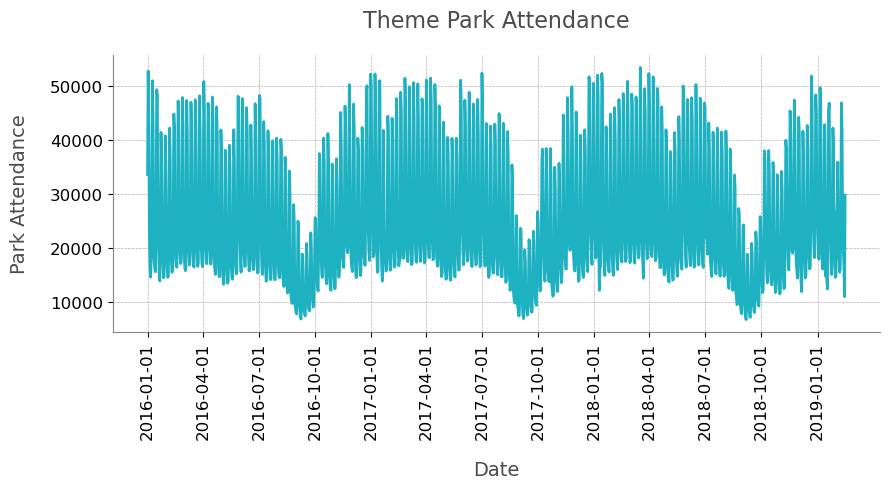

In [972]:
series_col = "series"
epoch_col = 'date'
time_col = 'date'
value_col = 'final_attendance'

# Generate a list of quarterly dates from 2016 to 2019
quarterly_dates = pd.date_range(start='2016-01-01', end='2019-3-31', freq='QS').tolist()


# Adjusting the spacing between axis titles and tick labels
plt.figure(figsize=(9, 5))

# Set title and labels with a medium contrast
font = {
#     'family': 'serif',
    'color':  '#4B4B4B',
    'weight': 'normal'
}

# Plotting the data
plt.plot(timeseries_df[epoch_col], timeseries_df[value_col], color='#1db1c1', linewidth=2)

# Adjusting the title and labels with increased spacing
plt.xlabel('Date', fontsize=14, fontdict=font, labelpad=15)
plt.ylabel('Park Attendance', fontsize=14, fontdict=font, labelpad=15)
plt.title('Theme Park Attendance', fontsize=16, fontdict=font, pad=20)

# Adjusting x and y ticks
plt.xticks(quarterly_dates, rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Grid and spines adjustments
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='#B0B0B0')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')

plt.tight_layout()
plt.savefig(outp_fig_fname)
plt.show()

# Save Data

In [973]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
    
timeseries_df.sort_values(by=[series_col, epoch_col], inplace=True)
timeseries_df[all_cols].to_csv(outp_fname, index=False)

In [974]:
timeseries_df.shape

(1142, 72)